# 含并行连结的网络（GoogLeNet）
:label:`sec_googlenet`

在2014年的ImageNet图像识别挑战赛中，一个名叫*GoogLeNet* :cite:`Szegedy.Liu.Jia.ea.2015`的网络架构大放异彩。
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到$1 \times 1$，大到$11 \times 11$的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

## (**Inception块**)

在GoogLeNet中，基本的卷积块被称为*Inception块*（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

![Inception块的架构。](../img/inception.svg)
:label:`fig_inception`

如 :numref:`fig_inception`所示，Inception块由四条并行路径组成。
前三条路径使用窗口大小为$1\times 1$、$3\times 3$和$5\times 5$的卷积层，从不同空间大小中提取信息。
中间的两条路径在输入上执行$1\times 1$卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用$3\times 3$最大汇聚层，然后使用$1\times 1$卷积层来改变通道数。
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

那么为什么GoogLeNet这个网络如此有效呢？
首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
同时，我们可以为不同的滤波器分配不同数量的参数。

## [**GoogLeNet模型**]

如 :numref:`fig_inception_full`所示，GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。
第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

![GoogLeNet架构。](../img/inception-full.svg)
:label:`fig_inception_full`

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用64个通道、$7\times 7$卷积层。


In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是64个通道、$1\times 1$卷积层；第二个卷积层使用将通道数量增加三倍的$3\times 3$卷积层。
这对应于Inception块中的第二条路径。


In [3]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三个模块串联两个完整的Inception块。
第一个Inception块的输出通道数为$64+128+32+32=256$，四个路径之间的输出通道数量比为$64:128:32:32=2:4:1:1$。
第二个和第三个路径首先将输入通道的数量分别减少到$96/192=1/2$和$16/192=1/12$，然后连接第二个卷积层。第二个Inception块的输出通道数增加到$128+192+96+64=480$，四个路径之间的输出通道数量比为$128:192:96:64 = 4:6:3:2$。
第二条和第三条路径首先将输入通道的数量分别减少到$128/256=1/2$和$32/256=1/8$。


In [4]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂，
它串联了5个Inception块，其输出通道数分别是$192+208+48+64=512$、$160+224+64+64=512$、$128+256+64+64=512$、$112+288+64+64=528$和$256+320+128+128=832$。
这些路径的通道数分配和第三模块中的类似，首先是含$3×3$卷积层的第二条路径输出最多通道，其次是仅含$1×1$卷积层的第一条路径，之后是含$5×5$卷积层的第三条路径和含$3×3$最大汇聚层的第四条路径。
其中第二、第三条路径都会先按比例减小通道数。
这些比例在各个Inception块中都略有不同。


In [5]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为$256+320+128+128=832$和$384+384+128+128=1024$的两个Inception块。
其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。
需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。
最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。


In [6]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。
[**为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96**]，这简化了计算。下面演示各个模块输出的形状变化。


In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [8]:
import subprocess
import time

In [9]:
def run_powermetrics(file_path):
    """
    Run powermetrics and retrieve the output.

    :param interval: Sampling interval in milliseconds.
    :param count: Number of samples to retrieve.s
    :return: The output from powermetrics.
    """

    # Define the command as a list of arguments
    cmd = ["sudo", "powermetrics",  "-i", "1000", "--samplers", "cpu_power,gpu_power", "-a", "1", "-o", file_path]
    
    process = subprocess.Popen(cmd)
    return process

In [10]:
def txt_data_process(file_path):
    """
    Read the output file of powermetric and extract the power value

    :param file_path: The path of the output file of powermetric.
    :return: The list of power values.
    """

    list_power = []
    with open(file_path, 'r') as f:
        for line in f:
            if 'Combined Power' in line:
                power_value = line.split(':')[1].strip()
                print(power_value)

                # Remove the unit
                power_value = power_value.replace('mW', '')

                # Convert to integer
                power_value = int(power_value)
                list_power.append(power_value)

    print(list_power)
    print(len(list_power))

    # do the data process
    '''
    The data from list_power is the Conbined Power of each second.
    The data is the Power of each second.
    we need to calculate the energy consumption of the whole process.
    and need to change the J to kWh.
    '''
    # calculate the energy consumption
    energy_consumption = 0
    for i in range(len(list_power)):
       energy_consumption += list_power[i]
    print(energy_consumption)

    # change the mW to W
    energy_consumption = energy_consumption / 1000

    # calculate the energy consumption, the interval is 1 second, and the energy unit is J
    energy_consumption = energy_consumption * 1
    
    # change the J to kWh
    energy_consumption = energy_consumption / 3600000
    print(energy_consumption)
    
    return energy_consumption, list_power


In [11]:
def calculate_idle(file_path_idle):
    # run powermetrics
    idle_process = run_powermetrics(file_path_idle)

    # wait for 30 seconds
    time.sleep(30)

    # kill the powermetrics process
    idle_process.terminate()
    idle_process.wait()

    # calculate the average power consumptions
    idle_energy_consumption, idle_list = txt_data_process(file_path_idle)
    avg_idel_energy_consumption = idle_energy_consumption / len(idle_list)
    print('The average idle energy consuption per second is ', avg_idel_energy_consumption, 'kWh')

    return avg_idel_energy_consumption, idle_list

In [12]:
file_path_idle = "pm_idle_final_googlenet.txt"
avg_idel_energy_consumption, idle_list = calculate_idle(file_path_idle)

431 mW
456 mW
442 mW
451 mW
459 mW
540 mW
463 mW
3129 mW
9131 mW
7047 mW
1053 mW
2433 mW
2741 mW
1033 mW
484 mW
599 mW
609 mW
422 mW
561 mW
3706 mW
1252 mW
313 mW
302 mW
317 mW
473 mW
1048 mW
546 mW
718 mW
[431, 456, 442, 451, 459, 540, 463, 3129, 9131, 7047, 1053, 2433, 2741, 1033, 484, 599, 609, 422, 561, 3706, 1252, 313, 302, 317, 473, 1048, 546, 718]
28
41159
1.1433055555555555e-05
The average idle energy consuption per second is  4.083234126984127e-07 kWh


In [13]:
# Create the file name by appending the time string to the file path
file_path_run = "pm_calculate_final_googlenet.txt"
# print(file_path_run)

In [14]:
# import the time lib to calculate the running time
time_start = time.time()

# run powermetrics
powermetrics_process = run_powermetrics(file_path_run)

## [**训练模型**]

和以前一样，我们使用Fashion-MNIST数据集来训练我们的模型。在训练之前，我们将图片转换为$96 \times 96$分辨率。


loss 0.245, train acc 0.905, test acc 0.893
387.7 examples/sec on mps


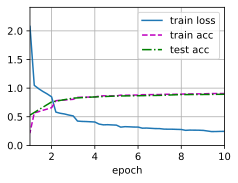

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr,'mps')

In [16]:
powermetrics_process.terminate()
powermetrics_process.wait()

time_end = time.time()

In [17]:
# calculate the total running time
time_total = time_end - time_start
print("The total running time is: ", time_total)

The total running time is:  1660.546625137329


In [18]:
energy_consumption, power_list_model = txt_data_process(file_path_run)
total_training_time = len(power_list_model)

7571 mW
5267 mW
5011 mW
5264 mW
5019 mW
4880 mW
4628 mW
5527 mW
4868 mW
4822 mW
5262 mW
7042 mW
5520 mW
4943 mW
4870 mW
5264 mW
4962 mW
4915 mW
5191 mW
4863 mW
4930 mW
4776 mW
8606 mW
9349 mW
9288 mW
9454 mW
9697 mW
9271 mW
9252 mW
10220 mW
9972 mW
9752 mW
9753 mW
12026 mW
12507 mW
11010 mW
10029 mW
9704 mW
9269 mW
9213 mW
10639 mW
10830 mW
9963 mW
9192 mW
9159 mW
9358 mW
9284 mW
9072 mW
9150 mW
9239 mW
9278 mW
9172 mW
10800 mW
9528 mW
9534 mW
11154 mW
12580 mW
14343 mW
9269 mW
9315 mW
9322 mW
9536 mW
9501 mW
9786 mW
9758 mW
9235 mW
11583 mW
10075 mW
10651 mW
9279 mW
9411 mW
13389 mW
9651 mW
10030 mW
9314 mW
9425 mW
9245 mW
9270 mW
9293 mW
9325 mW
9317 mW
9223 mW
10917 mW
9543 mW
9399 mW
9413 mW
9381 mW
9338 mW
9392 mW
9388 mW
9387 mW
9435 mW
9296 mW
9351 mW
9342 mW
9446 mW
9258 mW
9410 mW
9331 mW
9329 mW
12478 mW
9383 mW
10012 mW
9250 mW
9380 mW
9977 mW
9329 mW
9382 mW
11834 mW
12117 mW
9686 mW
9342 mW
11206 mW
11890 mW
10266 mW
9366 mW
9340 mW
9426 mW
9546 mW
9465 mW
9377 mW
9405 mW


In [19]:
# calculate the energy consumption of the model
energy_consumption_model = energy_consumption - avg_idel_energy_consumption * total_training_time
system_energy_consumption = avg_idel_energy_consumption * total_training_time

# calculate the average power during running the model
model_power = 0
for i in range(len(power_list_model)):
    model_power += power_list_model[i]
avg_total_power = model_power / len(power_list_model)/ 1000

# calculate the average power during running the system
system_power = 0
for i in range(len(idle_list)):
    system_power += idle_list[i]
avg_system_power = system_power / len(idle_list) / 1000

avg_model_power = avg_total_power - avg_system_power

In [20]:
print('The average total power during running the model is: ', avg_total_power, 'W')
print('The average power during running the system is: ', avg_system_power, 'W')
print('The average power during running the model is: ', avg_model_power, 'W')
print('*' * 50)
print('The total training time is: ', total_training_time, 's')
print('*' * 50)
print('The total energy consumption is: ', energy_consumption, 'kWh')
# print('The average idle energy consuption per second is ', avg_idel_energy_consumption, 'kWh') 
print('The total system energy consumption during running the model is: ', system_energy_consumption, 'kWh')
print('The total energy consumption of the model is: ', energy_consumption_model, 'kWh')

The average total power during running the model is:  9.654828467153283 W
The average power during running the system is:  1.4699642857142858 W
The average power during running the model is:  8.184864181438998 W
**************************************************
The total training time is:  1644 s
**************************************************
The total energy consumption is:  0.004409038333333334 kWh
The total system energy consumption during running the model is:  0.0006712836904761905 kWh
The total energy consumption of the model is:  0.003737754642857143 kWh


## 小结

* Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用$1×1$卷积层减少每像素级别上的通道维数从而降低模型复杂度。
*  GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。
* GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。

## 练习

1. GoogLeNet有一些后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
    * 添加批量规范化层 :cite:`Ioffe.Szegedy.2015`（batch normalization），在 :numref:`sec_batch_norm`中将介绍；
    * 对Inception模块进行调整 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`；
    * 使用标签平滑（label smoothing）进行模型正则化 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`；
    * 加入残差连接 :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`。（ :numref:`sec_resnet`将介绍）。
1. 使用GoogLeNet的最小图像大小是多少？
1. 将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？


[Discussions](https://discuss.d2l.ai/t/1871)
